# Import Libraries/Packages & Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

## Set Working directory
## Load benign data, drop unwanted columns
 

In [2]:
fulldata = pd.read_csv('idsnew\CICIDS_ALLATTACKS.csv')
fulldata['Label'].value_counts()

Label
Benign                      4836398
DDoS attacks-LOIC-HTTP       573347
DoS attacks-Hulk             439126
DDOS attack-HOIC             360833
Bot                          285763
FTP-BruteForce               193354
SSH-Bruteforce               187589
Infilteration                152874
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         39924
DoS attacks-Slowloris          2724
DDOS attack-LOIC-UDP           1730
Brute Force -Web & XSS          544
Name: count, dtype: int64

In [3]:
train_datas = {}
test_datas = {}
mixed_data = pd.DataFrame()
for i in fulldata['Label'].unique():
    if fulldata[fulldata['Label'] == i].shape[0] > 100000:
        print(i)
        train_datas[i] = fulldata[fulldata['Label'] == i][:100000]
        test_datas[i] = fulldata[fulldata['Label'] == i][100000:110000]
        mixed_data = pd.concat([mixed_data, fulldata[fulldata['Label'] == i][110000:120000]], axis=0)

Benign
Bot
DDOS attack-HOIC
DDoS attacks-LOIC-HTTP
DoS attacks-Hulk
DoS attacks-SlowHTTPTest
FTP-BruteForce
Infilteration
SSH-Bruteforce


In [4]:
del fulldata

In [5]:
mixed_data = mixed_data.sample(frac=1).reset_index(drop=True)
mixed_data_labels = list(mixed_data['Label'])
mixed_data.drop(['Label'], axis=1, inplace=True)
mixed_data = mixed_data.to_numpy()
for i in train_datas:
    train_datas[i].drop(['Label'], axis=1, inplace=True)
    test_datas[i].drop(['Label'], axis=1, inplace=True)
    train_datas[i] = train_datas[i].sample(frac=1).reset_index(drop=True)
    test_datas[i] = test_datas[i].sample(frac=1).reset_index(drop=True)
    train_datas[i] = train_datas[i].to_numpy()
    test_datas[i] = test_datas[i].to_numpy()

In [6]:
#loading data into pytorch dataloader as train and test
devices = []
batch_size = 128
train_loader = {}
for i in train_datas:
  train_loader[i] = torch.utils.data.DataLoader(train_datas[i], batch_size = batch_size, shuffle=True)
  devices.append(i)

In [7]:
len(train_loader)

9

In [8]:
len(devices)

9

In [9]:
#initialising config variables
num_clients = len(train_loader)      # Number of clients
num_selected = len(train_loader)    # Typically, num_selected is around 30–40% of the num_clients.
#baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 5  #100      # Total number of communication rounds for the global model to train.
epochs = 50          # for train client model
#retrain_epochs = 3  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.

## FedAvg / FedAvgM

In [10]:
# aggregates the model weights received from every client
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias



In [11]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
          output = client_model(data.float()) # tensor 115
          optimizer.zero_grad()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(device), output)
          loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())

## Deep Auto-encoder Model

In [12]:
import torch.nn as nn

input_dim = train_loader['Benign'].dataset.shape[1]

class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        
        xavier_gain = nn.init.calculate_gain('tanh')
        
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 8)
        self.fc6 = nn.Linear(8, 16)
        self.fc7 = nn.Linear(16, 32)
        self.fc8 = nn.Linear(32, input_dim)
        self.fc9 = nn.Linear(input_dim, input_dim)
       
        self.activation = nn.Tanh()
        
        nn.init.xavier_uniform_(self.fc1.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc2.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc3.weight, gain=xavier_gain) 
        nn.init.xavier_uniform_(self.fc4.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc5.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc6.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc7.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc8.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc9.weight, gain=xavier_gain)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        x = self.fc8(x) 
        x = self.activation(x)
        x = self.fc9(x)
        return x

## Initialisation

In [13]:
# Initializing models and optimizer

global_model = AEModel(input_dim).to(device)
client_models = [AEModel(input_dim).to(device) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
#opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]

# Training Federated Model

In [14]:
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []
train_loss_per_client = [[] for i in range(num_clients)]
train_loss_benign = []

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    #client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    client_idx = list(range(num_clients))
    print('client_idx: ', client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] # Need to fix this. It is part of server aggregation.
    # client_lens = [len(train_lotrain_loaderader[idx]) for idx in client_idx ]
    #print(client_lens)


    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected)):
        # print(i)
        #client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        if devices[client_idx[i]] != 'Benign':
            l = client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
            train_loss_per_client[i].append(l)
            loss += l
    train_loss_client.append(loss)

    #### benign client update ####
    for i in tqdm(range(1)):
        l = client_update(client_models[-1], opt[-1], train_loader['Benign'], epochs)
        train_loss_benign.append(l)
    train_loss_per_client[-1] = train_loss_benign
    train_loss_client.append(sum(train_loss_benign))


    #### retraining on the global server ####
    #loss_retrain = 0
    #for i in tqdm(range(num_selected)):
    #    loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    #train_loss_global.append(loss_retrain/num_selected)

    attackclients = []
    for i in devices:
        if i != 'Benign':
            attackclients.append(client_models[devices.index(i)])
    
    ### aggregate models ###
    server_aggregate(global_model, attackclients, client_lens)      # FedAvg
    #server_aggregate_M(global_model, attackclients, client_lens)    # FedAvgM

    print("\nclient_loss: ", loss)
    #print('global_loss: ', loss_retrain/num_selected)

time_required = time.time() - start_time
print('/nTIME: {}mins'.format(time_required/60))


round:  1
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [01:44<00:00, 104.55s/it]



client_loss:  0.032775146429430566

round:  2
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [01:44<00:00, 104.38s/it]



client_loss:  0.02747200693410147

round:  3
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [01:44<00:00, 104.83s/it]



client_loss:  0.08999766209869398

round:  4
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [01:43<00:00, 103.46s/it]



client_loss:  0.034853593974025376

round:  5
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [01:44<00:00, 104.29s/it]


client_loss:  0.002711240139479297
/nTIME: 90.18486713171005mins


In [15]:
for i in range(len(train_loss_per_client)):
  print(train_loss_per_client[i])

[]
[0.0021917502500909997, 0.0017675405767623603, 0.0549714343648337, 0.000211647409914129, 0.00019953077713822482]
[0.020404848679804893, 1.65888134530257e-05, 9.652185158848645e-05, 1.0267249279450599e-05, 9.479811522122154e-05]
[5.779551253124834e-05, 0.0004585140280425567, 4.7821559223441394e-05, 4.875827103217296e-05, 0.000152714462381161]
[0.0012489794053064654, 0.00021946085840435353, 0.00020915618249098473, 0.0002236761067340182, 0.001215761120095724]
[2.032896166516166e-05, 0.023927799875396803, 2.792836878661849e-05, 1.2473044468125035e-05, 4.345871638565361e-05]
[5.1014993656383496e-05, 4.687667074215794e-05, 2.937594412580666e-05, 0.00336356684142757, 4.1230747177663955e-05]
[0.008634679776299602, 0.0008650954068868238, 0.034560377645405135, 0.030817623733711975, 0.000795791557085786]
[0.0038901376502250163, 0.00017013070441339144, 0.007724735611940131, 5.5046182239803016e-05, 0.0019355597890927778, 0.00016558131745793438, 0.001077387122409966, 0.00016795464399386236, 0.007

In [16]:
# save model
torch.save(global_model,'C:/Final Year Project/modelsnew/globalattackmodel.pt')

In [17]:
for i in range(len(devices)):
  torch.save(client_models[i],'C:/Final Year Project/modelsnew/clients/' + devices[i] + '.pt')

In [18]:
losspic = 1
def printperformance(losses, modelname):
    global losspic
    plt.plot(losses)
    plt.xlabel('number of rounds')
    plt.ylabel('loss')
    plt.ylim((0, 2.5))
    plt.grid()
    plt.title(modelname)
    plt.show()
    plt.savefig("C:/Final Year Project/images/" + str(modelname) + str(losspic) + ".png")
    losspic += 1

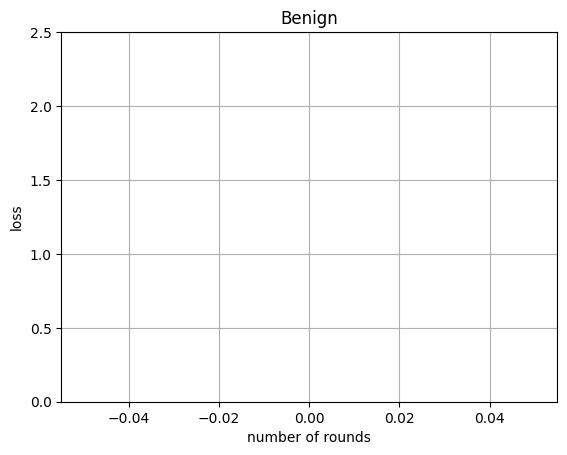

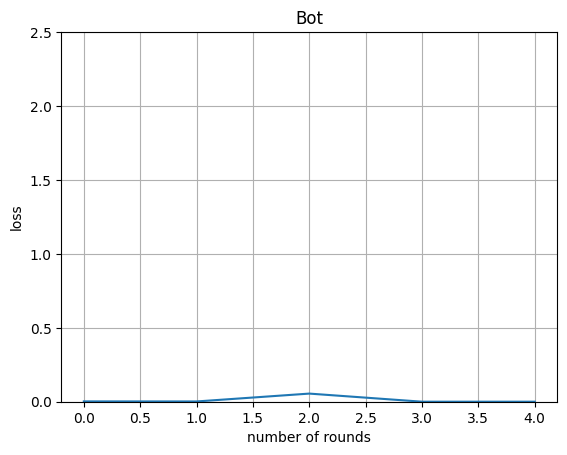

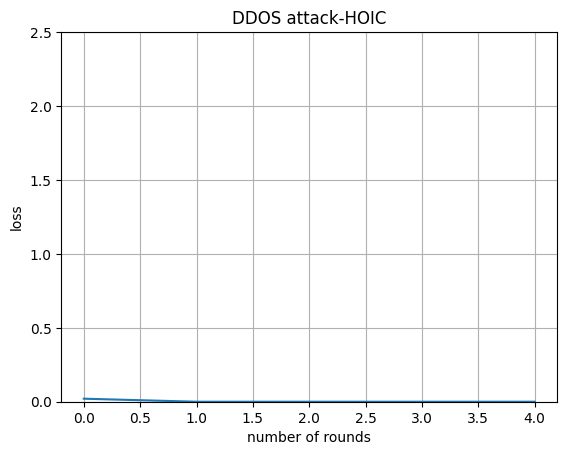

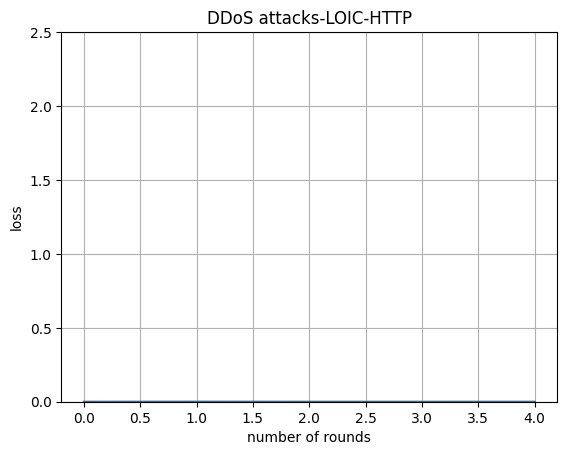

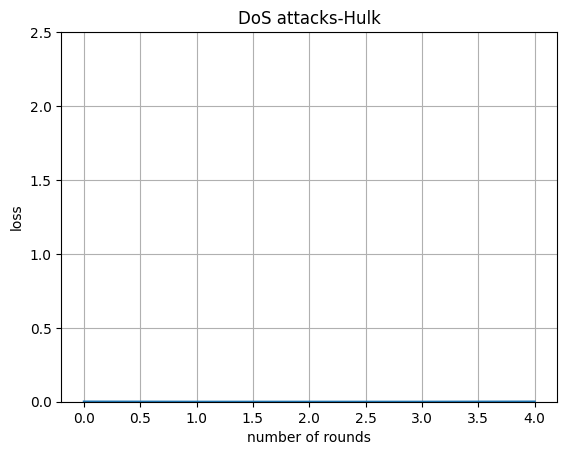

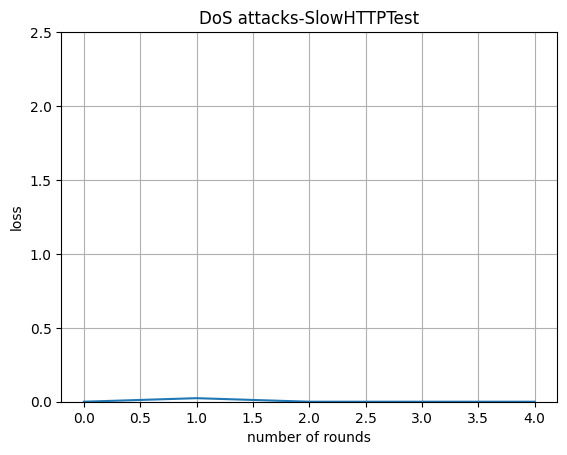

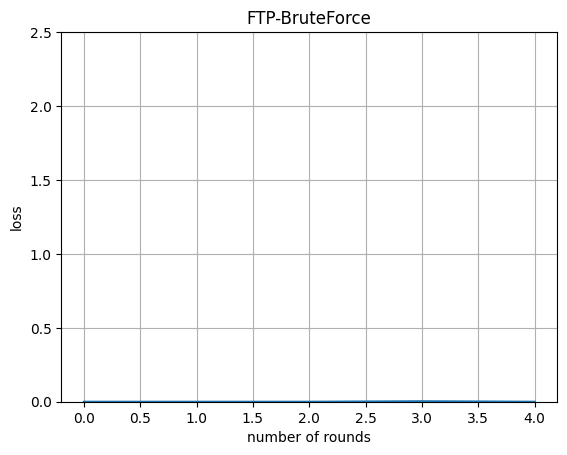

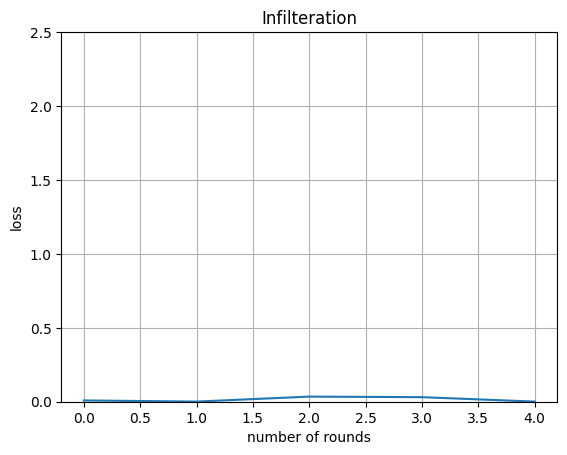

<Figure size 640x480 with 0 Axes>

In [19]:
for i in range(len(devices)-1):
  printperformance(train_loss_per_client[i], devices[i])

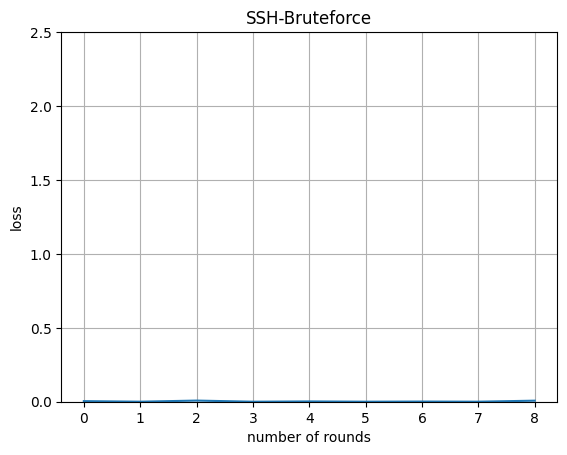

<Figure size 640x480 with 0 Axes>

In [20]:
# print performance of benign client
printperformance(train_loss_benign, devices[-1])

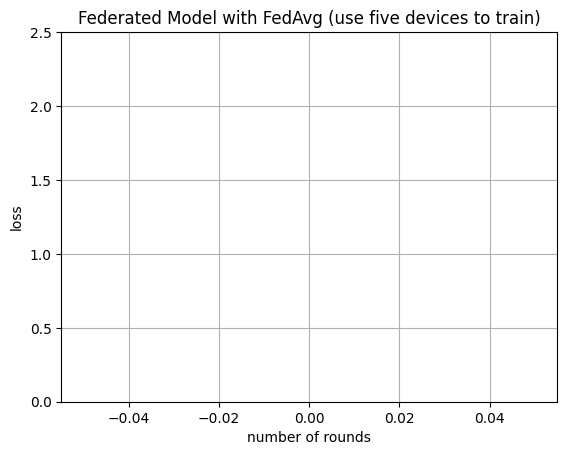

<Figure size 640x480 with 0 Axes>

In [21]:
# train_loss_global
plt.plot(train_loss_global)
plt.xlabel('number of rounds')
plt.ylabel('loss')
plt.ylim((0, 2.5))
plt.grid()
plt.title('Federated Model with FedAvg (use five devices to train)')
plt.show()
plt.savefig("C:/Final Year Project/images/Global10.png")

# Evaluation

In [23]:
client_models = {}
for device in devices:
  client_models[device] = torch.load('C:/Final Year Project/modelsnew/clients/' + device + '.pt')

In [24]:
from sklearn import metrics

In [25]:
def get_thresh(model, dataloader):

    model.eval()
    errs = []
    mses = []
    for batch in dataloader:
       for data in batch:
         mse = np.power(data.float().cpu().detach().numpy() - model(data.float()).cpu().detach().numpy(), 2) #before np.mean(..., axis=0) (len(mse) = 56)
         mses.append(mse)
    mses = np.array(mses)
    print("MSES: " + str(mses.shape))
    thresh = mses.mean(axis=0) + mses.std(axis=0)
    print(thresh.shape)
    #errs.append(thresh)
    #thresh = sum(errs) / len(errs)
    return thresh

    #model.eval()
    #pred = global_model(tr_data).cpu().detach().numpy()
    #print(pred)
    #print(np.isnan(pred))
    #thresh = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
    #mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    #tr = np.sqrt(metrics.mean_squared_error(model(tr_data).cpu().detach().numpy(), tr_data.cpu().detach().numpy()))
    #tr = np.sqrt(mse)
    #return thresh

    
def quan_thresh(model, dataloader, quantile=0.9):

  model.eval()
  errs = []
  se = []
  
  for batch in dataloader:
    
    for data in batch:
      error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2) # len(error) = 66
      se.append(sum(error))
    # Calculate threshold as quantile of errors 
    #thresh = np.quantile(se, quantile, axis=0) #before it was thresh = np.quantile(mse, quantile)
    #errs.append(thresh)
  #thresh = np.quantile(mse, quantile)
  return np.mean(se) + np.std(se), np.quantile(se, quantile), se #before it was np.mean(errs)
  #return thresh

def quan_recon(model, dataloader, quantile=0.8):
  model.eval()
  datas = []
  for batch in dataloader:
    for data in batch:
      datas.append(model(data.float()).cpu().detach().numpy())
  thresh = np.quantile(datas, quantile, axis=0)
  return thresh

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
           TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
           FP += 1
        if y_actual[i] == y_pred[i] == 0:
           TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    prediction = []
    for i in mix_data:
      pred = model(i).cpu().detach().numpy()
      error = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
      if error > tr:
        prediction.append(1)
      else:
        prediction.append(0)

    mix_label_list = mix_label.tolist()

    TP,FP,TN,FN = perf_measure(mix_label_list, prediction)

    conf = [[TP, FN],[FP, TN]]
    print(conf)
    x_axis_label = ['abnormal', 'benign']
    y_axis_label = ['abnormal', 'benign']

    plt.figure()
    sns.heatmap(conf,xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16},fmt='g')

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100,
                                                                                                   precision,
                                                                                                   recall,
                                                                                                   F1score*100,
                                                                                                   TPR,
                                                                                                   FPR))

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [26]:
thresholds = {}
quans = {}
errors = {}
for device in devices:
    model = client_models[device]
    dataloader = train_loader[device]
    thresholds[device], quans[device], errors[device] = quan_thresh(model, dataloader)
    #thresholds[devices[i]] = quan_recon(model, dataloader)
print(thresholds)

{'Benign': 62.00266382594416, 'Bot': 0.12704842326129603, 'DDOS attack-HOIC': 0.03186978074405828, 'DDoS attacks-LOIC-HTTP': 0.05946233494438303, 'DoS attacks-Hulk': 0.45881401187094045, 'DoS attacks-SlowHTTPTest': 0.029151458770800793, 'FTP-BruteForce': 0.0032028976841999646, 'Infilteration': 0.2133161277309501, 'SSH-Bruteforce': 1.027715193742624}


In [27]:
quans

{'Benign': 65.01736634715417,
 'Bot': 0.0023586416906243276,
 'DDOS attack-HOIC': 0.00706199906948574,
 'DDoS attacks-LOIC-HTTP': 0.004227515608270993,
 'DoS attacks-Hulk': 0.03632143965937843,
 'DoS attacks-SlowHTTPTest': 0.011191370232894553,
 'FTP-BruteForce': 0.0039503417609744115,
 'Infilteration': 0.10751036209297102,
 'SSH-Bruteforce': 1.0417595808573972}

In [28]:
#@thresholds = {'Benign': 61.877983871320254, 'Bot': 0.09083680293611163, 'DDOS attack-HOIC': 1.8556977635303178, 'DoS attacks-Hulk': 0.11400531390823192, 'DoS attacks-SlowHTTPTest': 0.21217828694483437, 'FTP-BruteForce': 0.0029948042571023934, 'Infilteration': 3.799426671646207, 'SSH-Bruteforce': 1.0148292389310203}
# mean + std of sse for 2 round 50 epoch

In [29]:
#thresholds={'Benign': 61.87798387132028, 'Bot': 0.09161945656969754, 'DDOS attack-HOIC': 0.025858257999281466, 'DoS attacks-Hulk': 0.13915533441081115, 'DoS attacks-SlowHTTPTest': 0.007261200969461876, 'FTP-BruteForce': 0.0034343920695094742, 'Infilteration': 0.832359128599836, 'SSH-Bruteforce': 2.8281726392384123}
# 5 round 50 epoch

In [30]:
len(thresholds)

9

In [31]:
devices

['Benign',
 'Bot',
 'DDOS attack-HOIC',
 'DDoS attacks-LOIC-HTTP',
 'DoS attacks-Hulk',
 'DoS attacks-SlowHTTPTest',
 'FTP-BruteForce',
 'Infilteration',
 'SSH-Bruteforce']

In [32]:
c = lambda lst, x: len([y for y in lst if y < x])
for i in devices:
    print(c(errors[i], quans[i]))

90000
90000
90000
90000
90000
89999
89994
90000
90000


In [33]:
for i in devices:
    print(c(errors[i], thresholds[i]))

85041
98233
95876
99756
95372
99264
80438
95883
80948


In [34]:
def quan_thresh_test(model, testset, quantile=0.9):
    model.eval()
    se = []
    for data in testset:
        data = torch.Tensor(data)
        error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2) # len(error) = 66
        se.append(sum(error))
    return np.mean(se) + np.std(se), np.quantile(se, quantile), se

In [35]:
thresholds_test = {}
quans_test = {}
errors_test = {}
for device in devices:
    model = client_models[i]
    testset = test_datas[device]
    thresholds_test[device], quans_test[device], errors_test[device] = quan_thresh_test(model, testset)
print(thresholds_test)

{'Benign': 1.0153862193937508, 'Bot': 2.3820916594531143, 'DDOS attack-HOIC': 1.9363925973145029, 'DDoS attacks-LOIC-HTTP': 1.6774284092485194, 'DoS attacks-Hulk': 2.031123645587968, 'DoS attacks-SlowHTTPTest': 1.7207220599816606, 'FTP-BruteForce': 2.5743621324835253, 'Infilteration': 1.9779552625525603, 'SSH-Bruteforce': 1.0244921300628032}


In [36]:
for i in devices:
    print(i, c(errors_test[i], thresholds[i]))

Benign 10000
Bot 0
DDOS attack-HOIC 0
DDoS attacks-LOIC-HTTP 0
DoS attacks-Hulk 0
DoS attacks-SlowHTTPTest 0
FTP-BruteForce 0
Infilteration 2486
SSH-Bruteforce 8114


In [37]:
for i in devices:
    print(c(errors_test[i], quans[i]))

10000
0
0
0
0
0
0
240
9002


### What the model is supposed to find = 1 (Error < Threshold)
### What the model is not supposed to find = 0 (Error > Threshold)

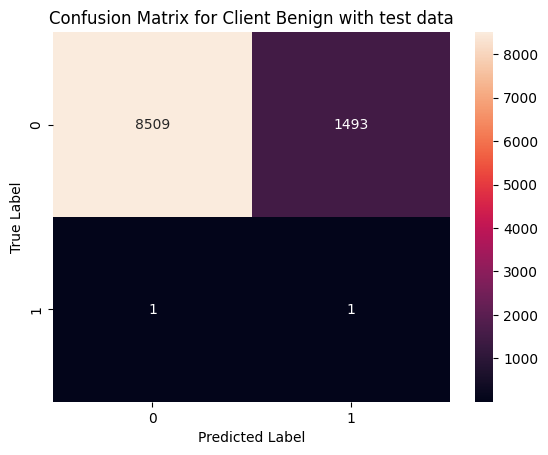

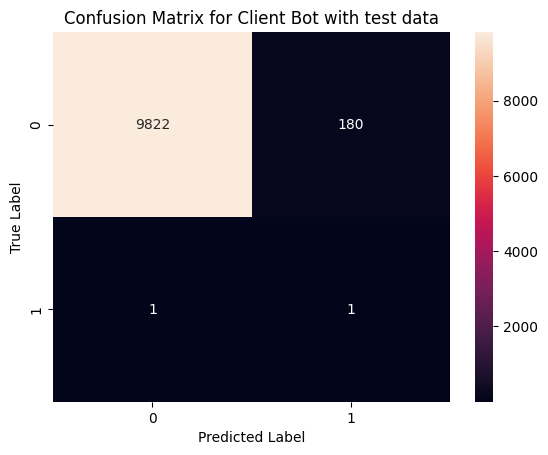

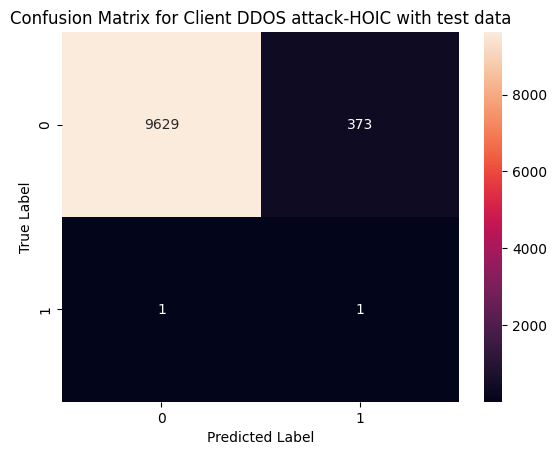

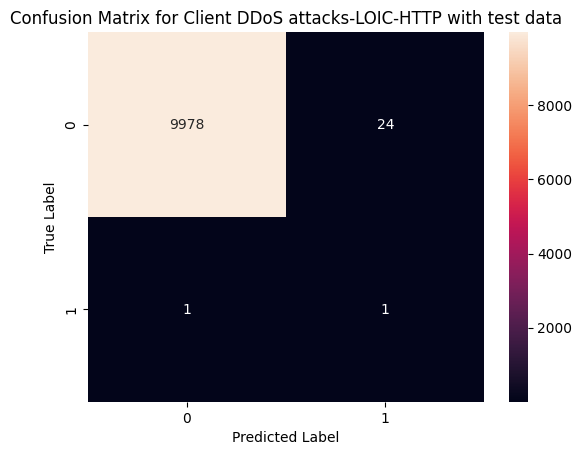

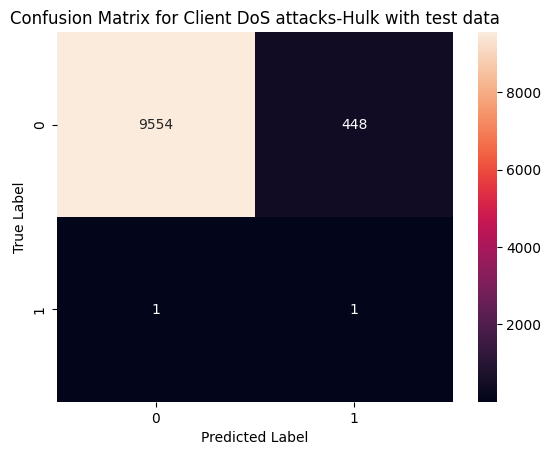

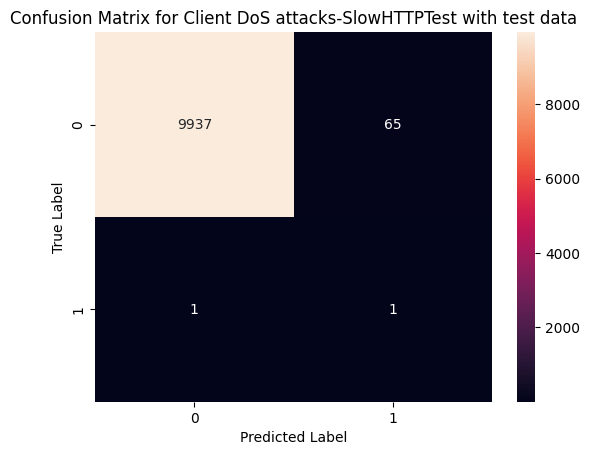

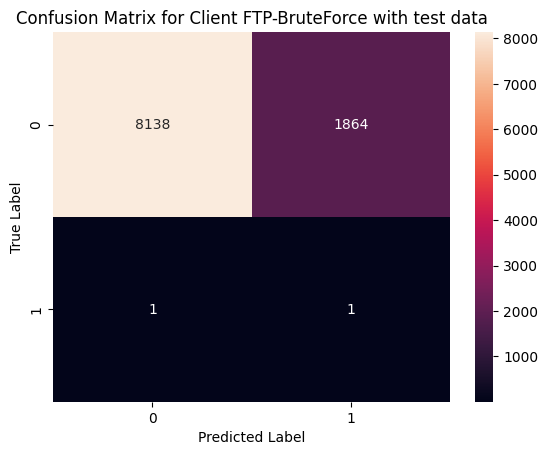

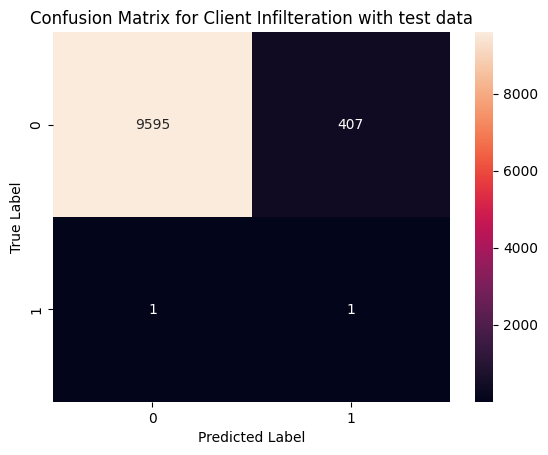

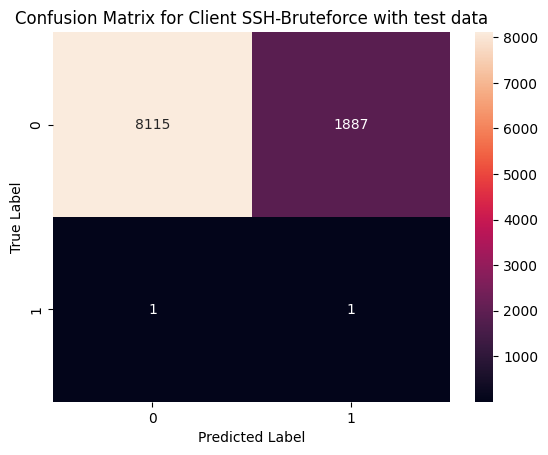

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
res=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  model = client_models[device]
  model.eval()
  labels = device
  threshold = thresholds[device]
  temp=[]
  y_true = []
  y_pred = []
  ind = 0
  for data in test_datas[device]:
      data = torch.Tensor(data)
      error = np.sum(np.power(data.detach().numpy() - model(data).detach().numpy(), 2))
      temp.append(error)
      if device == labels:
          y_true.append(1)
          y_pred.append(1 if error < threshold else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if error >= threshold else 1)
      #cf.append([coeff, p, device[:-4] == labels[ind]])
      ind += 1
  res.append([device,min(temp),max(temp)])
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  TP += 1
  FN += 1
  TN += 1
  FP += 1
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure() 
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client " + str(device) +" with test data")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  acc = (TP+TN) / (TP+TN+FP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1score = 2 * ((precision * recall) / (precision + recall))

  TPR = round((TP / (TP+FN)), 6)
  # print('TPR is: {}%'.format(TPR))

  FPR = round((FP / (FP + TN)), 6)
  # print('TPR is: {}%'.format(FPR))

  selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with test data"),acc*100,precision,recall,F1score*100,TPR,FPR])

  #   [['TP', 'FN']
  #   ['FP', 'TN']]

Plot for global model

In [39]:
# load model
global_model = torch.load('C:/Final Year Project/models/globalattackmodel.pt')                                        

# Testing client models with equal number of all data (selected and not selected)

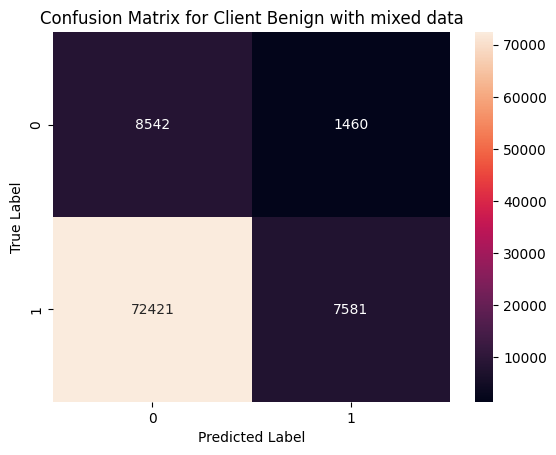

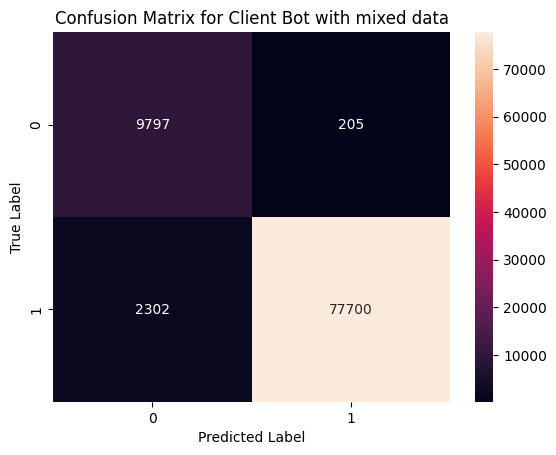

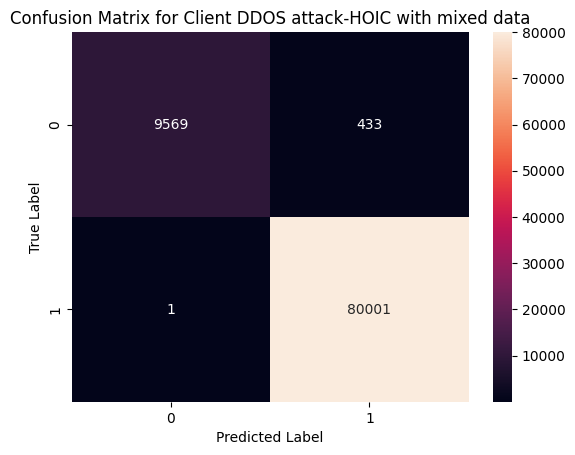

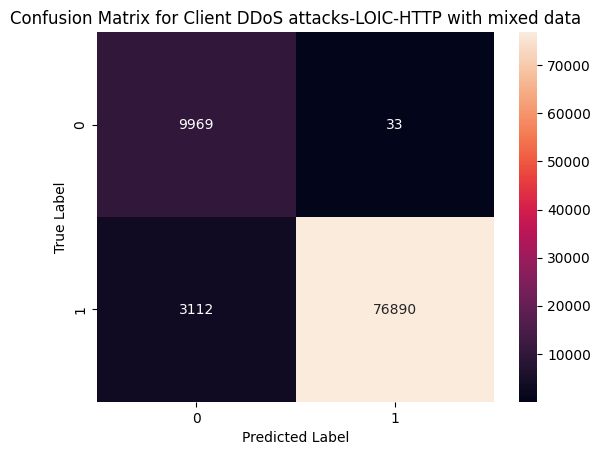

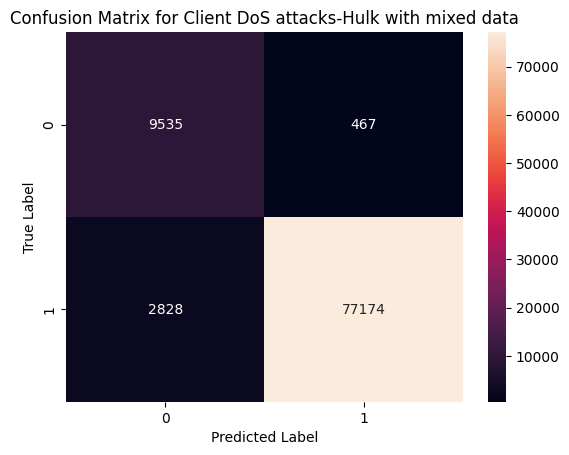

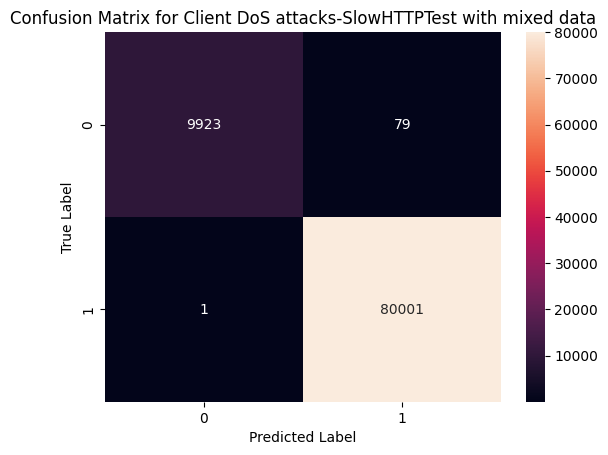

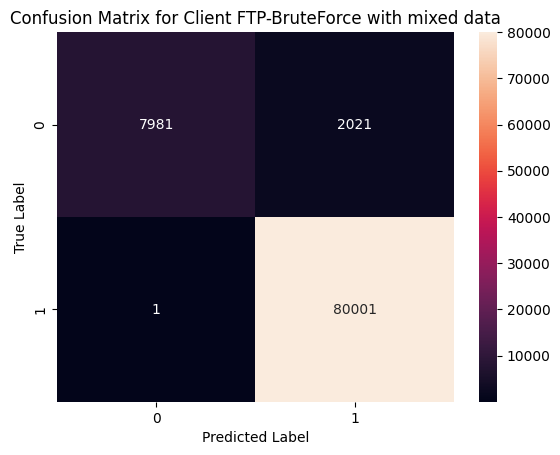

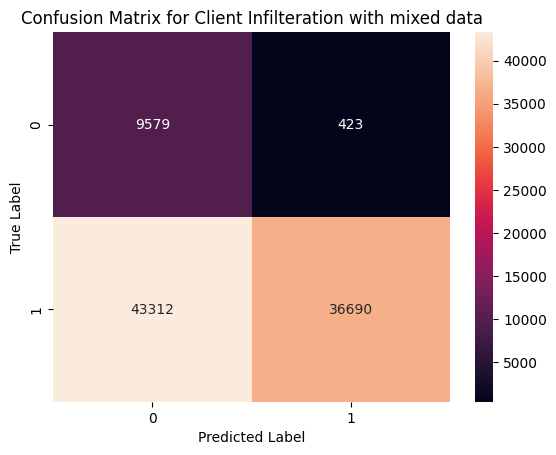

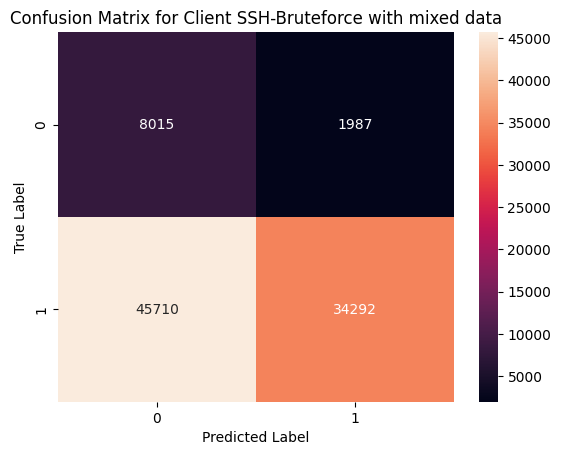

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
res=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
#  if device == 'Infilteration.csv':
  model = client_models[device]
  model.eval()
  labels = mixed_data_labels
  threshold = thresholds[device]
  temp=[]
  y_true = []
  y_pred = []
  ind = 0
  for data in mixed_data:
      data = torch.Tensor(data)
      error = np.sum(np.power(data.detach().numpy() - model(data).detach().numpy(), 2))
      temp.append(error)
      if device == labels[ind]:
          y_true.append(1)
          y_pred.append(1 if error < threshold else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if error >= threshold else 1)
      #cf.append([coeff, p, device[:-4] == labels[ind]])
      ind += 1
  res.append([device,min(temp),max(temp)])
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  TP += 1
  FN += 1
  TN += 1
  FP += 1
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure() 
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client " + str(device) +" with mixed data")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  acc = (TP+TN) / (TP+TN+FP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1score = 2 * ((precision * recall) / (precision + recall))

  TPR = round((TP / (TP+FN)), 6)
  # print('TPR is: {}%'.format(TPR))

  FPR = round((FP / (FP + TN)), 6)
  # print('TPR is: {}%'.format(FPR))

  selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with mixed data"),acc*100,precision,recall,F1score*100,TPR,FPR])

  #   [['TP', 'FN']
  #   ['FP', 'TN']]

In [41]:
res

[['Benign', 37.46202, 98.521126],
 ['Bot', 0.00027338677, 16.96283],
 ['DDOS attack-HOIC', 0.00037731638, 16.846916],
 ['DDoS attacks-LOIC-HTTP', 9.369731e-05, 17.487825],
 ['DoS attacks-Hulk', 0.0006062458, 12.422992],
 ['DoS attacks-SlowHTTPTest', 6.3617963e-06, 19.774391],
 ['FTP-BruteForce', 4.007177e-05, 20.000668],
 ['Infilteration', 0.0104190605, 9.491447],
 ['SSH-Bruteforce', 0.0122654075, 10.540789]]

In [42]:
thresholds

{'Benign': 62.00266382594416,
 'Bot': 0.12704842326129603,
 'DDOS attack-HOIC': 0.03186978074405828,
 'DDoS attacks-LOIC-HTTP': 0.05946233494438303,
 'DoS attacks-Hulk': 0.45881401187094045,
 'DoS attacks-SlowHTTPTest': 0.029151458770800793,
 'FTP-BruteForce': 0.0032028976841999646,
 'Infilteration': 0.2133161277309501,
 'SSH-Bruteforce': 1.027715193742624}

In [43]:
for i in selectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Client Benign with mixed data
Accuracy: 17.913648282298563
Precision: 0.10550498375801291
Recall: 0.8540291941611677
F1 score : 18.78084977738691
TPR : 0.854029
FPR : 0.90524
Title: Stats for Client Bot with mixed data
Accuracy: 97.2145682414115
Precision: 0.8097363418464336
Recall: 0.979504099180164
F1 score : 88.65662187231348
TPR : 0.979504
FPR : 0.028774
Title: Stats for Client DDOS attack-HOIC with mixed data
Accuracy: 99.51779920892405
Precision: 0.9998955067920585
Recall: 0.9567086582683463
F1 score : 97.78254649499284
TPR : 0.956709
FPR : 1.2e-05
Title: Stats for Client DDoS attacks-LOIC-HTTP with mixed data
Accuracy: 96.50571085729524
Precision: 0.7620976989526794
Recall: 0.9967006598680264
F1 score : 86.3752545163107
TPR : 0.996701
FPR : 0.038899
Title: Stats for Client DoS attacks-Hulk with mixed data
Accuracy: 96.33905159770677
Precision: 0.7712529321362129
Recall: 0.9533093381323735
F1 score : 85.26715850659514
TPR : 0.953309
FPR : 0.035349
Title: Stats fo

In [ ]:
import matplotlib
matplotlib.pyplot.close()

# Testing global model with equal number of all data (selected only) (not selected does not have threshold)

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
res=[]
model = global_model
model.eval()
labels = mixed_data_labels
temp=[]
y_true = []
y_pred = []
ind = 0
errors_global = []
for data in mixed_data:
    data = torch.Tensor(data)
    error = np.sum(np.power(data.detach().numpy() - model(data).detach().numpy(), 2))
    errors_global.append(error)
'''
    temp.append(error)
    threshold = thresholds[labels[ind]]
    if labels[ind] == 'Benign':
        threshold = max(thresholds.values())
        y_true.append(0)
        y_pred.append(0 if error >= threshold else 1)
    else:
        y_true.append(1)
        y_pred.append(1 if error <= threshold else 0)
    ind += 1
res.append([device,min(temp),max(temp)])
TP, FP, TN, FN = perf_measure(y_true, y_pred)
TP += 1
FN += 1
TN += 1
FP += 1
conf_matrix = [[TP, FN], [FP, TN]]
plt.figure() 
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix for Client " + str(device) +" with mixed data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

acc = (TP+TN) / (TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1score = 2 * ((precision * recall) / (precision + recall))

TPR = round((TP / (TP+FN)), 6)
# print('TPR is: {}%'.format(TPR))

FPR = round((FP / (FP + TN)), 6)
# print('TPR is: {}%'.format(FPR))

selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with mixed data"),acc*100,precision,recall,F1score*100,TPR,FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]
'''

'\n    temp.append(error)\n    threshold = thresholds[labels[ind]]\n    if labels[ind] == \'Benign\':\n        threshold = max(thresholds.values())\n        y_true.append(0)\n        y_pred.append(0 if error >= threshold else 1)\n    else:\n        y_true.append(1)\n        y_pred.append(1 if error <= threshold else 0)\n    ind += 1\nres.append([device,min(temp),max(temp)])\nTP, FP, TN, FN = perf_measure(y_true, y_pred)\nTP += 1\nFN += 1\nTN += 1\nFP += 1\nconf_matrix = [[TP, FN], [FP, TN]]\nplt.figure() \nsns.heatmap(conf_matrix, annot=True, fmt="d")\nplt.title("Confusion Matrix for Client " + str(device) +" with mixed data")\nplt.xlabel("Predicted Label")\nplt.ylabel("True Label")\n\nacc = (TP+TN) / (TP+TN+FP+FN)\nprecision = TP/(TP+FP)\nrecall = TP/(TP+FN)\nF1score = 2 * ((precision * recall) / (precision + recall))\n\nTPR = round((TP / (TP+FN)), 6)\n# print(\'TPR is: {}%\'.format(TPR))\n\nFPR = round((FP / (FP + TN)), 6)\n# print(\'TPR is: {}%\'.format(FPR))\n\nselectedattackbenmix

In [ ]:
for i in selectedattackbenmix_stats_global:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Globel Model with trained attack dataframe
Accuracy: 44.47469001377716
Precision: 0.8010587739878482
Recall: 0.49933751656208597
F1 score : 61.519507819297615
TPR : 0.499338
FPR : 0.991902


In [ ]:
import matplotlib
matplotlib.pyplot.close()

In [45]:
print(max(errors_global), min(errors_global))

175.83151 77.62728


In [46]:
thresholds

{'Benign': 62.00266382594416,
 'Bot': 0.12704842326129603,
 'DDOS attack-HOIC': 0.03186978074405828,
 'DDoS attacks-LOIC-HTTP': 0.05946233494438303,
 'DoS attacks-Hulk': 0.45881401187094045,
 'DoS attacks-SlowHTTPTest': 0.029151458770800793,
 'FTP-BruteForce': 0.0032028976841999646,
 'Infilteration': 0.2133161277309501,
 'SSH-Bruteforce': 1.027715193742624}

In [47]:
quans

{'Benign': 65.01736634715417,
 'Bot': 0.0023586416906243276,
 'DDOS attack-HOIC': 0.00706199906948574,
 'DDoS attacks-LOIC-HTTP': 0.004227515608270993,
 'DoS attacks-Hulk': 0.03632143965937843,
 'DoS attacks-SlowHTTPTest': 0.011191370232894553,
 'FTP-BruteForce': 0.0039503417609744115,
 'Infilteration': 0.10751036209297102,
 'SSH-Bruteforce': 1.0417595808573972}

In [48]:
mixed_data_labels

['DoS attacks-SlowHTTPTest',
 'FTP-BruteForce',
 'Benign',
 'SSH-Bruteforce',
 'FTP-BruteForce',
 'Bot',
 'SSH-Bruteforce',
 'FTP-BruteForce',
 'Benign',
 'DoS attacks-Hulk',
 'FTP-BruteForce',
 'DDoS attacks-LOIC-HTTP',
 'DoS attacks-Hulk',
 'Benign',
 'DDoS attacks-LOIC-HTTP',
 'DoS attacks-Hulk',
 'DDoS attacks-LOIC-HTTP',
 'SSH-Bruteforce',
 'DoS attacks-SlowHTTPTest',
 'SSH-Bruteforce',
 'Infilteration',
 'Benign',
 'DoS attacks-SlowHTTPTest',
 'DDoS attacks-LOIC-HTTP',
 'DoS attacks-SlowHTTPTest',
 'Benign',
 'Benign',
 'Infilteration',
 'Bot',
 'DDoS attacks-LOIC-HTTP',
 'Infilteration',
 'Infilteration',
 'Benign',
 'Bot',
 'DoS attacks-SlowHTTPTest',
 'DoS attacks-SlowHTTPTest',
 'Infilteration',
 'DDOS attack-HOIC',
 'Benign',
 'Infilteration',
 'Benign',
 'DoS attacks-Hulk',
 'DDoS attacks-LOIC-HTTP',
 'DDoS attacks-LOIC-HTTP',
 'DDoS attacks-LOIC-HTTP',
 'Infilteration',
 'DoS attacks-SlowHTTPTest',
 'Benign',
 'Benign',
 'DDOS attack-HOIC',
 'Benign',
 'DoS attacks-SlowHTT

In [53]:
thresholds

{'Benign': 62.00266382594416,
 'Bot': 0.12704842326129603,
 'DDOS attack-HOIC': 0.03186978074405828,
 'DDoS attacks-LOIC-HTTP': 0.05946233494438303,
 'DoS attacks-Hulk': 0.45881401187094045,
 'DoS attacks-SlowHTTPTest': 0.029151458770800793,
 'FTP-BruteForce': 0.0032028976841999646,
 'Infilteration': 0.2133161277309501,
 'SSH-Bruteforce': 1.027715193742624}

In [69]:
clientthresh=[]
for i in thresholds:
    if i!='Benign':
        clientthresh.append(thresholds[i])
clientthresh

[0.12704842326129603,
 0.03186978074405828,
 0.05946233494438303,
 0.45881401187094045,
 0.029151458770800793,
 0.0032028976841999646,
 0.2133161277309501,
 1.027715193742624]

In [70]:
globalmin=min(errors_global)
dist=[abs(t-globalmin) for t in clientthresh]
weights=[1/d for d in dist]
weights=weights/np.sum(weights)
weighted_avg_thresh=np.sum(weights*clientthresh)

In [74]:
dist

[175.70446402791057,
 175.79964267042783,
 175.7720501162275,
 175.37269843930093,
 175.80236099240108,
 175.82830955348768,
 175.6181963234409,
 174.80379725742924]

In [73]:
min(errors_global)

77.62728